In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import os 

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
    
print(f'Current Working Directory: {os.getcwd()}')

from utils.config import chosen_portfolio
from utils.finance_utils import plot_cum_ret

chosen_portfolio

Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py
Updated on 03/12/2025 12:30

---------------------------------
finance_utils.py successfully loaded, updated last March. 17 2025 7:32
---------------------------------




{'Risky Asset Weight': 0.8382894952657721,
 'Risk-Free Asset Weight': 0.16171050473422788,
 'Stocks': ['DE', 'NEM', 'CQP', 'GRMN', 'CSCO', 'VST', 'RCL', 'MPLX', 'SGOV'],
 'Stock Weights': [0.015581233401949376,
  0.007306133337610667,
  0.10209469131664765,
  0.1740786200572725,
  0.3540262805274835,
  0.053924304833807196,
  0.10649307073932002,
  0.02478516105168133,
  0.16171050473422788],
 'Expected Portfolio Return': 0.3102012919562827,
 'Expected Portfolio Standard Deviation': 0.13413692573975414,
 'Note': 'Portfolio includes T-bills (expected std > benchmark std).'}

In [ ]:

def merge_stock_df(stocks: list, stock_weights: list, existing_df: pd.DataFrame, paper_money: float) -> pd.DataFrame:
    """
    Merge existing valuation DataFrame with a simulated portfolio.
    
    Parameters:
    stocks (list): List of stock tickers in the portfolio.
    stock_weights (list): Corresponding weight allocations for each stock.
    existing_df (pd.DataFrame): DataFrame containing stock valuation data.
    paper_money (float): Total portfolio value, default is $30,000.
    
    Returns:
    pd.DataFrame: Merged DataFrame containing stock tickers, allocations, and valuation data.
    """
    real_allocation = dict(zip(np.array(stocks), (np.array(stock_weights)*paper_money)))
    real_allocation_df = pd.DataFrame(list(real_allocation.items()), columns=['Tickers', 'Weights_dollar'])
    
    merged_df = pd.merge(left=real_allocation_df, right=existing_df, on='Tickers', how='left')
    
    return merged_df.sort_values(by='Weights_dollar', ascending=False)




def get_stock_info(stocks: list, info_to_get: list) -> pd.DataFrame:
    if len(stocks) > 50:
        return 'Please set up logging, before getting info'
    
    end_list = []  # List of dictionaries

    for stock in stocks:
        stock_info = yf.Ticker(stock).info
        stock_data = {val: stock_info.get(val) for val in info_to_get}
        stock_data['Tickers'] = stock  # Add ticker symbol
        end_list.append(stock_data)  
        
    df = pd.DataFrame(end_list)
    
    if 'exDividendDate' in df.columns:
        df['exDividendDate'] = pd.to_datetime(df['exDividendDate'], unit='s')
    # Convert list of dictionaries into DataFrame
    return df

In [ ]:
CASH = 30_000.89 # adjust cash here to see dollar avraging cost

valuation_df = pd.read_csv('data/clean/filtered_valuation_df.csv')
portfolio = merge_stock_df(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], valuation_df, paper_money=CASH)

vals_to_get = ['industry', 'beta', 'averageAnalystRating', 'country', 'dividendYield', 'exDividendDate', 'overallRisk', 'currentPrice'] # KPI's to get from yf

In [ ]:
stock_info_sharpe = get_stock_info(portfolio['Tickers'].to_list(), vals_to_get) # df of val to get, and respective values
complete_portfolio_info = pd.merge(left=portfolio, right=stock_info_sharpe, left_on='Tickers', right_on='Tickers')

In [ ]:
complete_portfolio_info['Num_of_shares'] = complete_portfolio_info['Weights_dollar']/complete_portfolio_info['currentPrice'] # simply seeing total num of shares for avaibale option strategies
complete_portfolio_info.sort_values(by='Weights_dollar', ascending=False)

,Tickers,Weights_dollar,Sector,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,Sharpe_ratios,industry,beta,averageAnalystRating,country,dividendYield,exDividendDate,overallRisk,currentPrice,Num_of_shares
0,CSCO,10621.103499,Technology,2.406865e+11,26.535088,15.512820,0.16958,2.28,1.337912,Communication Equipment,0.854,2.1 - Buy,United States,2.86,2025-04-03,4.0,57.41,185.004416
1,GRMN,5222.513532,Technology,4.115522e+10,29.341562,28.672922,0.22415,7.29,1.365872,Scientific & Technical Instruments,0.938,2.9 - Hold,Switzerland,1.90,2025-06-16,9.0,192.10,27.186432
2,SGOV,4851.459064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,4.89,NaT,NaN,NaN,NaN
3,RCL,3194.886901,Consumer Cyclical,5.706073e+10,19.380257,14.836949,0.17452,10.94,1.663071,Travel Services,2.271,1.7 - Buy,United States,1.56,2025-03-07,8.0,191.82,16.655651
4,CQP,3062.931604,Energy,3.069348e+10,14.920000,14.746510,0.28837,4.25,1.886115,Oil & Gas Midstream,0.553,3.9 - Underperform,United States,5.59,2025-02-10,NaN,59.57,51.417351
5,VST,1617.777138,Utilities,4.218746e+10,17.805437,18.037682,0.15438,6.99,1.493509,Utilities - Independent Power Producers,1.230,1.7 - Buy,United States,0.80,2025-03-20,3.0,112.69,14.355996
6,MPLX,743.576890,Energy,5.453046e+10,12.667459,12.092972,0.38784,4.21,2.334357,Oil & Gas Midstream,1.062,2.1 - Buy,United States,7.94,2025-02-03,NaN,49.60,14.991470
7,DE,467.450869,Industrials,1.296002e+11,21.137670,21.538115,0.12993,22.59,1.215406,Farm & Heavy Construction Machinery,1.012,2.3 - Buy,United States,1.41,2025-03-31,7.0,467.67,0.999531
8,NEM,219.190503,Basic Materials,5.210601e+10,16.167833,12.073108,0.17921,2.86,1.024503,Gold,0.559,1.9 - Buy,United States,1.82,2025-03-04,2.0,54.79,4.000557


[**********************70%*********              ]  7 of 10 completed

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


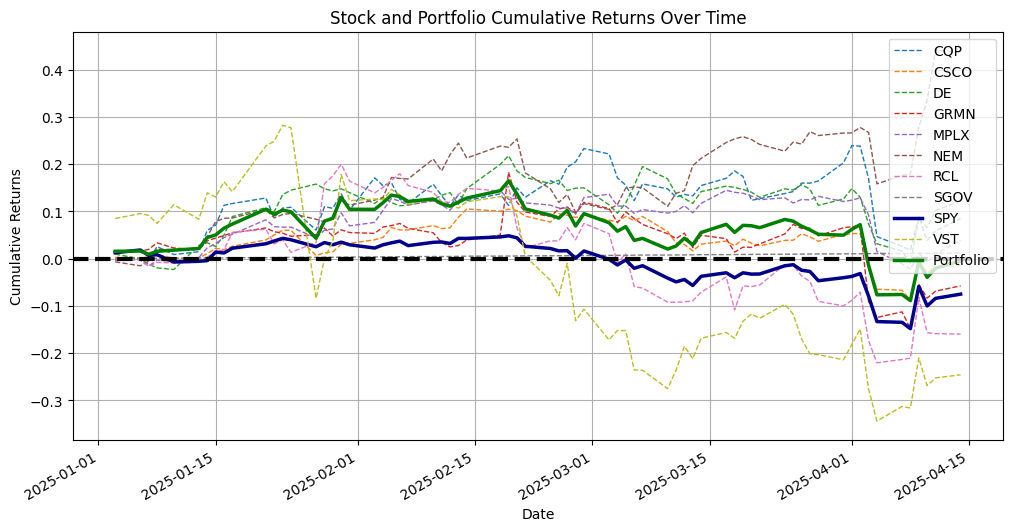

In [9]:
# plot stress test on portfolio, against a benchmark

stress_start = '2025-01-01'
stress_end = '2026-01-01'

plot_cum_ret(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], start_date=stress_start, end_date=stress_end)